# Homework 2 (HW2)
By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

- Homework release: Fri 17 Nov 2023	

- **Homework Due**: Fri 01 Dec 2023, 23:59	

- Grades released: Mon 11 Dec 2023	


---

## Some rules
1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.

2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)

3. Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.

4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation **(in markdown)**.

5. Back up any hypotheses and claims with data, since this is an important aspect of the course.

6. Please write all your comments in **English**, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. **If there are multiple notebooks present, we will not grade anything.**

7. We will **not run your notebook for you!** Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

8. In continuation to the previous point, interactive plots, such as those generated using the `plotly` package, should be strictly avoided!

9. Make sure to print results and/or dataframes that confirm you have properly addressed the task.


---

In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import ttest_ind

sns.set(rc={'figure.figsize':(15,8)})

## Context

After two years, the EPFL Baseball Club is broke. The new Dean transferred all funds to EPFL's new poster child: its super-competitive Pétanque club. After struggling so much to learn about baseball, you have unfortunately been laid off...

*(...) 1 month after, you manage to get another job (!) (...)*

Congratulations! You have just been hired as a data scientist at the Association for Computational Linguistics (ACL), a professional organization for people working on natural language processing. The ACL organizes several of the top conferences and workshops in the field of computational linguistics and natural language processing.
Your boss, Dr. Tiancheng, knows of your expertise in observational studies and asks you to investigate a question that’s been bothering everyone who has ever submitted a paper to a conference: should I spend time on writing rebuttals?



---

## Rebuttals, conferences, and getting your papers accepted

Rebuttals in ACL (Association for Computational Linguistics) conferences and in many other academic conferences are an important part of the peer-review process. They allow authors of submitted papers to respond to the reviews and comments provided by the reviewers before a final decision is made regarding the acceptance of the paper. Here's how the rebuttal process typically works in ACL conferences:

- Paper Submission: Authors submit their research papers to the ACL conference for review. These papers present novel research findings in computational linguistics, natural language processing, and related areas.
- Peer Review: The papers undergo a peer-review process after the initial submission. The program committee or reviewers are experts in the field who evaluate the papers based on their quality, significance, novelty, methodology, and other relevant criteria. They provide comments and scores for each paper.
- Rebuttal Period: After receiving the reviews, authors are given a specific period (usually around a week) to write a rebuttal. The rebuttal is a formal response to the reviewers' comments. It allows authors to clarify misunderstandings, address concerns, and provide additional information to support their paper's quality. 
- Final Review: After receiving the rebuttals, the reviewers may reconsider their initial assessments in light of the authors' responses. Reviewers may choose to maintain or adjust their reviews and scores based on the quality and effectiveness of the author's rebuttal.
- Final Decision: The program committee or conference organizers consider the initial reviews/scores, rebuttals, and revised reviews/scores to make a final decision on the acceptance of the papers. The decision can be acceptance, rejection, or conditional acceptance with a request for revisions.


---

## Data

- `tmp_id`: Unique identifier for each paper in the format "P{number}".
- `status`: Accept or Reject.
- `submission_type`: Short vs. Long (papers can have different lengths). We do not use this column in this homework. 
- `track`: Track to which the paper was submitted, broadly speaking, the "topic" of the paper.
- `scores_before`: Scores received before rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework. 
- `scores_after`: Scores received after rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework.
- `had_rebuttal`: True or False.


Note that: 
 - reviews are assigned numbers, e.g., "2";
 - papers can have different numbers of reviews;
 - review numbers are arbitrary, e.g., `P1` in the dataframe has two reviews numbered "2" and "3" (but no review "1").


## Task 1 (10 pts): Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

- You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
- When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

**1.1** Load the dataset containing ACL reviews into memory using pandas. 
- For each paper, create rows `overall_score_before_avg` and `overall_score_after_avg` containing the average (overall) scores before and after rebuttal.
- For each paper, create rows `overall_score_before_std` and `overall_score_after_std` containing the standard deviation of the overall scores before and after the rebuttal.
- Print the four newly created rows for paper `P17`.
- Print the resulting dataframe.

## Imports

In [2]:
# Load dataset
acl_df = pd.read_json('data/acl18_v1_numerical_final.json')
acl_df.head()

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True


In [3]:
# Create rows 'overall_score_before_avg` and `overall_score_after_avg'
def compute_score_averages(scores):
    return np.mean(np.array([scores[score]['scores']['overall_score'] for score in scores.keys()]))
 
acl_df['overall_score_before_avg'] = acl_df['scores_before'].map(compute_score_averages)
acl_df['overall_score_after_avg'] = acl_df['scores_after'].map(compute_score_averages)
acl_df.head()

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000


In [4]:
# Create rows `overall_score_before_std` and `overall_score_after_std`
def compute_score_std(scores):
    return np.std(np.array([scores[score]['scores']['overall_score'] for score in scores.keys()]))
 
acl_df['overall_score_before_std'] = acl_df['scores_before'].map(compute_score_std)
acl_df['overall_score_after_std'] = acl_df['scores_after'].map(compute_score_std)
acl_df.head()

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,0.500000
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,0.942809
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,0.471405
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,1.247219
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,0.500000


In [5]:
# Print the newly created values for P17
print(f"P17 average overall score before rebuttal: {acl_df.loc[acl_df['tmp_id'] == 'P17','overall_score_before_avg'].iloc[0]}")
print(f"P17 average overall score after rebuttal: {acl_df.loc[acl_df['tmp_id'] == 'P17','overall_score_after_avg'].iloc[0]}")
print(f"P17 standard deviation of overal score before rebuttal: {acl_df.loc[acl_df['tmp_id'] == 'P17','overall_score_before_std'].iloc[0]}")
print(f"P17 standard deviation of overal score after rebuttal: {acl_df.loc[acl_df['tmp_id'] == 'P17','overall_score_after_std'].iloc[0]}")

P17 average overall score before rebuttal: 4.5
P17 average overall score after rebuttal: 4.5
P17 standard deviation of overal score before rebuttal: 0.5
P17 standard deviation of overal score after rebuttal: 0.5


In [6]:
# Display dataframe
display(acl_df)

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,0.500000
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,0.942809
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,0.471405
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,1.247219
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
1540,P1541,Reject,Short,Textual Inference and Other Areas of Semantics,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,2.333333,2.333333,0.471405,0.471405
1541,P1542,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,2.000000,0.816497,0.816497
1542,P1543,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.666667,2.666667,0.942809,0.942809
1543,P1544,Reject,Short,Social Media,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,2.000000,0.000000,0.000000


**1.2** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain two panels: 
- **Panel A**: The distribution of `overall_score_before_avg` for papers that were accepted and papers that were rejected.
- **Panel B**: The distribution of `overall_score_before_avg` for papers that had rebuttals vs. papers that did not.

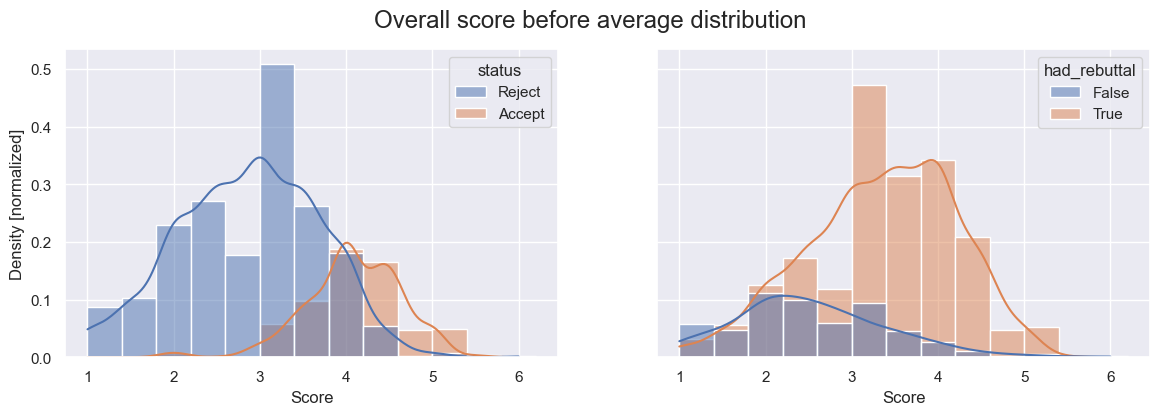

In [7]:
fig, ax = plt.subplots(1,2,figsize= (14,4), sharey = True, sharex = False)
fig.suptitle('Overall score before average distribution', fontsize='x-large')

sns.histplot(data=acl_df, x="overall_score_before_avg", hue="status", ax=ax[0], stat='density' ,binwidth=0.4, kde=True)
sns.histplot(data=acl_df, x="overall_score_before_avg", hue="had_rebuttal", ax=ax[1], stat='density' ,binwidth=0.4, kde=True)

ax[0].set_xlabel('Score')
ax[1].set_xlabel('Score')
ax[0].set_ylabel('Density [normalized]')
plt.show()

**1.3** **/Discuss/:** If you know a paper had a rebuttal, is it more or less likely that it was accepted? Does this mean that rebuttals help papers get accepted? Explain why or why not, providing a concrete example.

If we know a paper had a rebuttal, it is more likely that it was accepted. Indeed, the right plot of task 1.2 clearly shows that papers with a rebuttal have higher scores than those without. On the other hand, the left plot shows that having a higher scores increases the chances of being accepted, so rebuttal seems to be correlated with acceptance.

Whether this correlation means that rebuttals help papers get accepted is another matter, however, as that would imply a causal link between the two. However, this can't be concluded from just these two plots. It is indeed possible that papers with a higher scores thought they had good chances of getting accepted and therefore took the time to write a rebuttal. 

- The left plot of task 1.2 indeed shows that papers with a score below 3 hardly ever get accepted for instance - authors with very low scores therefore have less incentive to write a rebuttal. In fact, papers with very low scores almost never get accepted despite the fact that a fairly substantial proportion of them writes a rebuttal. This allows us to conclude that for scores below 3 rebuttals probably have no effect on acceptance. 

- From a score of 3, there is a sudden jump in the fraction of rebuttals - authors might simply know that from this score on there is a gradually increasing change of acceptance, as the left plot shows. From a score of about 4.5, almost all papers wrote a rebuttal, so it is impossible to conclude whether the rebuttals had any effect on acceptance (it is in fact quite likely that only the high scores mattered). 

- The score range 3 to 4.5 is the most interesting one: a significant proportion of authors wrote a rebuttal, but not all, and only a fraction (which varies quite a lot throughout this interval) of papers get accepted. Further analysis will be needed to conclude on any causal relationship between rebuttals and acceptance.

**1.4** Print the percentage of rebuttals per track in the conference (defined by the `track` column). 

**/Discuss:/** Using "the logic" of hypothesis testing (see slide 29 of Lecture 4), how would you devise a statistical test to refute the following null hypothesis: all tracks have the same fraction of papers with rebuttals. Your statistical test should consider all categories at once, rather than comparing the fraction of rebuttals between pairs of categories.

In [8]:
# Percentage of rebuttals per track
acl_percentage_track_series = acl_df.groupby('track')[['had_rebuttal']].apply(lambda x: f"{np.round(np.mean(x.had_rebuttal)*100, 2)} %").sort_values(ascending=False).copy()
acl_percentage_track_df = pd.DataFrame(acl_percentage_track_series, columns=['percentage_rebuttals'])
print("\t\t     PERCENTAGE OF REBUTTALS PER TRACK\n")
print(f"{'Track':<60} {'Percentage':>10}\n")
for track in acl_percentage_track_series.index:
    print(f"{f'{track}':<60} - {f'{acl_percentage_track_series[track]}':>10}")

		     PERCENTAGE OF REBUTTALS PER TRACK

Track                                                        Percentage

Word-level Semantics                                         -    86.08 %
Phonology Morphology and Word Segmentation                   -    85.19 %
Machine Translation                                          -    82.08 %
Vision Robotics Multimodal Grounding and Speech              -    81.13 %
Machine Learning                                             -    80.87 %
Multilinguality                                              -    80.65 %
Discourse and Pragmatics                                     -    80.43 %
Sentence-level semantics                                     -    78.89 %
Sentiment Analysis and Argument Mining                       -    78.82 %
Generation                                                   -    77.97 %
Dialogue and Interactive Systems                             -    77.53 %
Textual Inference and Other Areas of Semantics               -    77.19

To test for refutal of the null hypothesis that all tracks have the same fraction of papers with rebuttals, we could do a one-way independent ANOVA test. According to [Kent State University](https://libguides.library.kent.edu/spss/onewayanova#:~:text=One%2DWay%20ANOVA%20\(%22analysis,One%2DFactor%20ANOVA), a One-Way ANOVA ("analysis of variance") compares the means of two or more independent groups in order to determine whether there is statistical evidence that the associated population means are significantly different. One-Way ANOVA is a parametric test.

This description indeed matches our objective of comparing the mean fraction of rebuttals for different tracks. We chose this test by following the diagram of slide 29, lecture 4: we have one continous outcome variable, and one categorial predictor variable with more than two categories and different participants used in each category. We should, however, verify the following main two [assumptions](https://libguides.library.kent.edu/spss/onewayanova#:~:text=One%2DWay%20ANOVA%20\(%22analysis,One%2DFactor%20ANOVA) before using the ANOVA however:
- Normal distribution of the dependent variable for each group;
- Homogeneity of variance across groups.

If these assumptions don't hold, alternative tests such as the non-parametric [Kruskal–Wallis one-way analysis of variance](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) (see also slide 29, lecture 4) could be used instead.

## Task 2 (10pts): Prediction

You decide to investigate further the effect of rebuttals on acceptance using your machine learning skills.


**2.1** For each possible value in the `track` column, create a new column called {track}-onehot (e.g., for track=Generation, create Generation-onehot). Collectively, these new columns should "one hot-encode" the track column---for instance, if for a given paper the `track` column is filled with the value "Generation", the Generation-onehot column should equal 1 and all other {track}-onehot columns should equal 0. 

Print the column names of the resulting dataframe.

In [9]:
# Get one hot:
dummies = pd.get_dummies(acl_df['track']).astype('int')
acl_df_with_one_hot = pd.merge(acl_df,dummies,how='outer',left_index=True, right_index=True)

In [10]:
# Replace names
new_names = [dummy+"-onehot" for dummy in dummies.columns] 
dict(zip(dummies.columns,new_names))
acl_df_with_one_hot = acl_df_with_one_hot.rename(columns=dict(zip(dummies.columns,new_names)))

In [11]:
acl_df_with_one_hot.head()

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,...,Question Answering-onehot,Resources and Evaluation-onehot,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,...,0,0,0,0,0,0,0,0,0,0
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,...,1,0,0,0,0,0,0,0,0,0
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,...,0,0,0,0,0,0,0,0,0,0
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,...,0,0,0,0,0,0,0,0,0,0
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#print of the column names

names = []
names.append('1) ' + acl_df_with_one_hot.columns.values[0]+ '\n')

[names.append(str(j+1) + ') ' + x +'\n') for j,x in enumerate(acl_df_with_one_hot.columns.values[1:])]
print('The column names are:\n', ' '.join(names))

The column names are:
 1) tmp_id
 1) status
 2) submission_type
 3) track
 4) scores_before
 5) scores_after
 6) had_rebuttal
 7) overall_score_before_avg
 8) overall_score_after_avg
 9) overall_score_before_std
 10) overall_score_after_std
 11) Dialogue and Interactive Systems-onehot
 12) Discourse and Pragmatics-onehot
 13) Document Analysis-onehot
 14) Generation-onehot
 15) Information Extraction and Text Mining-onehot
 16) Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot
 17) Machine Learning-onehot
 18) Machine Translation-onehot
 19) Multidisciplinary and Area Chair COI-onehot
 20) Multilinguality-onehot
 21) Phonology Morphology and Word Segmentation-onehot
 22) Question Answering-onehot
 23) Resources and Evaluation-onehot
 24) Sentence-level semantics-onehot
 25) Sentiment Analysis and Argument Mining-onehot
 26) Social Media-onehot
 27) Summarization-onehot
 28) Tagging Chunking Syntax and Parsing-onehot
 29) Textual Inference and Other Areas of Semantics-


**2.2** Create a column `had_rebuttal_int`, which equals 1 if the paper had a rebuttal, and 0 otherwise, and a column `accepted_int`, which equals 1 if the paper was accepted, and 0 otherwise. 

In [13]:
acl_df_with_one_hot['had_rebuttal_int'] = (acl_df_with_one_hot['had_rebuttal']==True).astype(int)
acl_df_with_one_hot['accepted_int'] = (acl_df_with_one_hot['status']=='Accept').astype(int)
acl_df_with_one_hot.head()

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,...,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot,had_rebuttal_int,accepted_int
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,...,0,0,0,0,0,0,0,0,1,0
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,...,0,0,0,0,0,0,0,0,1,0
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,...,0,0,0,0,0,0,0,0,1,1
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,...,0,0,0,0,0,0,0,0,1,0
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,...,0,0,0,0,0,0,0,0,1,0


**2.3** Create a function `numpy_helper(df, cols)` to obtain a numpy.array out of your dataframe. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension `(NxM)` cast as a float.

In [14]:
def numpy_helper(df, cols):
    matrix = np.zeros((df.shape[0],len(cols)))
    for i, index in enumerate(df.index):
        matrix[i,:] = df.loc[index][cols].astype(float)
    return matrix


**2.4**
Create:
- an array of features X containing all track one-hot features, as well as the `overall_score_before_avg`,`overall_score_before_std`, and `had_rebuttal_int`;
- an array of outcomes y containing `accepted_int`. 


Print the shapes of both X and y (e.g., `X.shape`).

In [15]:
# Create X:
features_names = np.array(new_names+['overall_score_before_avg','overall_score_before_std','had_rebuttal_int'])
X = numpy_helper(acl_df_with_one_hot, features_names)
print("Shape of X : ",X.shape)

Shape of X :  (1538, 24)


In [16]:
# Create y:
y = numpy_helper(acl_df_with_one_hot, ['accepted_int'])
print("Shape of y : ",y.shape)

Shape of y :  (1538, 1)



**2.5** Build two `GradientBoostingClassifier` models using `sklearn` using the default parameters:
- Model 1: predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`, `overall_score_before_std`.
- Model 2:  predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`, `overall_score_before_std` **and** `had_rebuttal_int`.


For both models:

- Use the `cross_validate` function from `sklearn.model_selection` to compute the average precision, recall, and accuracy across test cross validation splits.

    - e.g., `cross_validate(clf, X, y, cv=30, scoring=('accuracy', 'precision', 'recall'))`

In [17]:
# Same as y but repeated for the sake of separation
y_train = numpy_helper(acl_df_with_one_hot, ['accepted_int'])

**Model 1**:

In [18]:
features_names = np.array(new_names+['overall_score_before_avg','overall_score_before_std'])
X_train = numpy_helper(acl_df_with_one_hot, features_names)
print(X_train.shape)
clf1 = GradientBoostingClassifier().fit(X_train, y_train.ravel())

(1538, 23)


In [19]:
clf_dict = cross_validate(clf1, X_train, y_train.ravel(), cv=30, scoring=('accuracy', 'precision', 'recall'))

clf1_cv = pd.DataFrame(clf_dict, columns=['test_accuracy','test_precision','test_recall'])

In [20]:
print("Cross validation on model 1 (30 runs):")
clf1_cv.mean()

Cross validation on model 1 (30 runs):


test_accuracy     0.837330
test_precision    0.708521
test_recall       0.592949
dtype: float64

**Model 2**:

In [21]:
features_names = np.array(new_names+['overall_score_before_avg','overall_score_before_std','had_rebuttal_int'])
X_train = numpy_helper(acl_df_with_one_hot, features_names)
print(X_train.shape)
clf2 = GradientBoostingClassifier().fit(X_train, y_train.ravel())

(1538, 24)


In [22]:
clf_dict = cross_validate(clf2, X_train, y_train.ravel(), cv=30, scoring=('accuracy', 'precision', 'recall'))

clf2_cv = pd.DataFrame(clf_dict, columns=['test_accuracy','test_precision','test_recall'])

In [23]:
print("Cross validation on model 2 (30 runs):")
clf2_cv.mean()

Cross validation on model 2 (30 runs):


test_accuracy     0.838650
test_precision    0.712681
test_recall       0.595726
dtype: float64


**2.6** Determine whether the difference in accuracy of the two models is statistically significant.


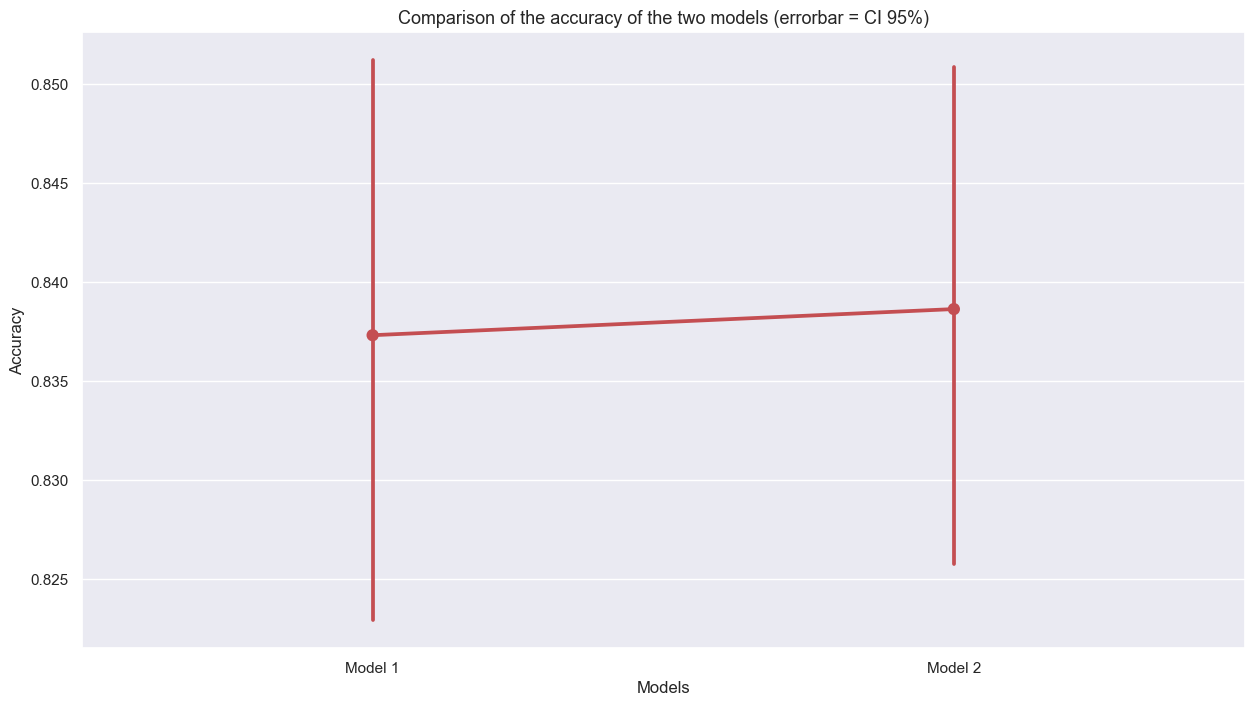

In [24]:
model_comparison_cv = pd.DataFrame({'model_1_accuracy':clf1_cv['test_accuracy'], 'model_2_accuracy':clf2_cv['test_accuracy'] })
sns.pointplot(data=model_comparison_cv.rename(columns={'model_1_accuracy': 'Model 1', 'model_2_accuracy': 'Model 2'}), estimator='mean', errorbar=('ci', 95), color = 'r')
plt.title('Comparison of the accuracy of the two models (errorbar = CI 95%)', size=13)
plt.xlabel('Models', size=12)
plt.ylabel('Accuracy', size=12)
plt.show()

We can asses graphically that we cannot reject the null hypothesis that the two accuracies are the same, as the confidence intervals significantly overlap.

In [25]:
t_stat, p_value = ttest_ind(model_comparison_cv['model_1_accuracy'], model_comparison_cv['model_2_accuracy'], equal_var=False)
print('The p-value is', p_value.round(5))

The p-value is 0.89768


Running the T-test the result yields the same conclusion as in the graphical intuition: the p-value is bigger than 0.05 so we can't reject the null hyphotesis. 

**2.7** Contrast the results obtained in **2.6** with what you observed in **Task 1**. What advantage did the analyses in **2.6** have?

In part 1, we didvided our data in 3 subsets: with low, medium and high scores. We were able to conclude that rebuttals had no effect on acceptance rates for low-score articles, but we were not able to conclude anything on the impact of rebuttals on publication outcomes for medium and high-score articles. 

In the present part, we see that adding the information "did the paper have a rebuttal or not", does not improve the model's power to predict the publication outcome (statistically not significantly different accuracies). This seems to confirm that writing a rebuttal doesn't have a foreseeable impact on the publication status.

## Task 3 (12pts): Interlude



**3.1** Using the formula API from `statsmodels`, estimate the following linear regression. Report the summary of the models.
- `accepted_int ~ had_rebuttal_int`,  
- `accepted_int ~ overall_score_after_avg`
- `had_rebuttal_int ~ overall_score_before_avg`

In [26]:
mod_rebuttal = smf.ols(formula='accepted_int ~ C(had_rebuttal_int)', data=acl_df_with_one_hot)
mod_overall_after = smf.ols(formula='accepted_int ~ overall_score_after_avg', data=acl_df_with_one_hot)
mod_overall_before = smf.ols(formula='had_rebuttal_int ~ overall_score_before_avg', data=acl_df_with_one_hot)

res_rebuttal = mod_rebuttal.fit()
res_overall_after = mod_overall_after.fit()
res_overall_before = mod_overall_before.fit()

In [27]:
print(res_rebuttal.summary())

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     66.22
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           8.24e-16
Time:                        14:34:16   Log-Likelihood:                -855.16
No. Observations:                1538   AIC:                             1714.
Df Residuals:                    1536   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [28]:
print(res_overall_after.summary())

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     1031.
Date:                Fri, 01 Dec 2023   Prob (F-statistic):          1.58e-173
Time:                        14:34:16   Log-Likelihood:                -492.65
No. Observations:                1538   AIC:                             989.3
Df Residuals:                    1536   BIC:                             1000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [29]:
print(res_overall_before.summary())

                            OLS Regression Results                            
Dep. Variable:       had_rebuttal_int   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     240.2
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.89e-50
Time:                        14:34:16   Log-Likelihood:                -727.42
No. Observations:                1538   AIC:                             1459.
Df Residuals:                    1536   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               


**3.2** **/Discuss:/** Interpret the coefficients associated with the binary independent variables in the above models. Note that independent variables are the ones on the right-handside of the equation.

- e.g., in `had_rebuttal_int ~ overall_score_before_avg`, `overall_score_before_avg` is the independent variable.



In the formula='accepted_int ~ C(had_rebuttal_int)', had_rebuttal_int is the independent variable, the coefficient is a categorical variable, and it can have only value 0 and 1, whether or not the author of the paper submitted a rebuttal. The predicted variable is the acceptance of the paper.

The coefficient associated with the variable C(had_rebuttal_int) is positive, significative (p-value = 0 approximately) and fairly large (magnitude of 0.21) . It seems that doing a rebuttal increases the chances of the paper being accepted by approximately 20 %. 

<!-- - The $R^2$ is low, this combination (significative coefficient and low $R^2$) suggests a connection between the independent variable and the dependent variable, yet it doesn't account for a significant portion of the variability in the dependent variable. -->


**3.3** **/Discuss:/** describe three correlations you can draw from the previous analysis. Describe their sign (i.e., whether they are positive or negative), and whether they are statistically significant (at the .05 level of significance).


We can retrieve the sign and p-value of the correlations by looking at the values given by the summaries of Task __3.1__:

- We can get the value of the correlation by taking the square root of the $R^2$: this is true when we consider only one independent variable (formal proof in the appendix). 

In [30]:
print("correlation between accepted_int and had_rebuttal_int is: ", np.sqrt(res_rebuttal.rsquared).round(4))
print("correlation between accepted_int and overall_score_after_avg is: ", np.sqrt(res_overall_after.rsquared).round(4))
print("correlation between had_rebuttal_int and overall_score_before_avg is: ", np.sqrt(res_overall_before.rsquared).round(4))

correlation between accepted_int and had_rebuttal_int is:  0.2033
correlation between accepted_int and overall_score_after_avg is:  0.6338
correlation between had_rebuttal_int and overall_score_before_avg is:  0.3678



- We can get the sign of the correlation by checking the sign of the value of $\beta_1$ in the regression formula $y = \beta_0 + \beta_1 x$. This is because correlation and covariances have the same sign, and the coefficient $\beta_1$ is proportional to the covariance and of the same sign as the covariance.

- For the statistical signficance, we can directly read the p-value of $\beta_1$.

An analysis of the summaries in __3.1__ shows that for the three correlations, we have:
- a positive sign (all coefficients are positive),

- statistical significance, as all p-values are (much) lower than 0.05.

<!-- The coefficients of the linear regression models above tell us how much the following variables are correlated:

- `accepted_int ~ had_rebuttal_int`: this regression show a very small $R^2 = 0.041$, this suggests that had_rebuttal is not a good predictor of acceptance. We obtain a positive correlation $\rho = 0.203$, with very small $P < 0.001$ (so statistically significant).

- `accepted_int ~ overall_score_after_avg`: this regression show a higher $R^2 = 0.402$, this suggests a strong relationship between the overall score after rebuttal and acceptance. Also in this case we obtain a positive correlation $\rho = 0.634$, with very small $P < 0.001$ (so statistically significant).

- `had_rebuttal_int ~ overall_score_before_avg`: this regression show $R^2 = 0.135$, this suggests a weak relationship between the overall score before rebuttal and submitting a rebuttal. Also in this case we obtain a positive correlation $\rho = 0.368$, with very small $P < 0.001$ (so statistically significant). -->

<!-- Some considerations can be made about the previous analysis:

- The analysis also shows how making a rebuttal by itself does not explain much of the variance of the dependent variable. 

- On the other hand, the analysis suggests all three variables have a positive and statistically significant correlations at 0.05 level of significance. -->

<!-- michelangelo thinks that this explanation could be augmented: read https://statisticsbyjim.com/regression/low-r-squared-regression/ and this https://stats.stackexchange.com/questions/509933/is-there-such-a-thing-as-a-too-low-r-squared-when-running-multiple-linear-regres -->

**3.4** **/Discuss:/** Is the following statement True or False? Justify. 

- The variable `overall_score_after_avg` explains more of the variance in `accepted_int`than the variable `overall_score_before_avg` explains of `had_rebuttal_int`.


The definition of $R^2$ is the amount of variance of the dependent variable, explained by the independent one.<p> 
To assess the given statement, we should therefore compare the $R^2$ of the two predictors:

- `accepted_int ~ overall_score_after_avg` shows $R^2 = 0.402$.
- `had_rebuttal_int ~ overall_score_before_avg` shows $R^2 = 0.135$.

As the first predictor has higher value of $R^2$, the statement is true.


**3.5** **/Discuss:/** Create a causal diagram relating the following variables:
- "Sa": `overall_score_after_avg`
- "Sb": `overall_score_before_avg`
- "Re": `had_rebuttal_int`
- "Ac": `accepted_int`
- "Tr": `track`


When unsure about whether a causal relationship exists, include it in the diagram. E.g., include the arrow corresponding to the key questions around this homework, i.e., `had_rebuttal_int`->`accepted_int`, even though you are investigating whether it exists. 

You may draw your diagram using text, use Sa/Sb/Re/Ac/Tr to represent the names of the variables, and simply indicate the causal links, one per line.


Instead of drawing something like this:
![](./dagv.jpeg)

Simply write:

- Tr->Sb
- Tr->Ac
- Tr->Re
- Ac->Sb
- Re->Sb
- Sb->Sa

---

We think that the following causal relationships might exist:

- Tr -> Re: the track could have an influence on how often rebuttals are written (it shouldn't have an impact on scores, however): it could be more common in some subjects to have to explain your choices in a rebuttal;

- Sb -> Re: people who get very low score may not bother writing a rebuttal as they have little chance of being published anyway;

- Sb -> Sa: the score after is highly influenced by the score before (it is still the same paper nevertheless);

- Re -> Sa: writing a rebuttal explaining your reasoning could help increase your score;

- Re -> Ac: reviewers may appreciate that the authors explained their choices further;

- Sa -> Ac and Sb -> Ac: a good score is more likely to be published.

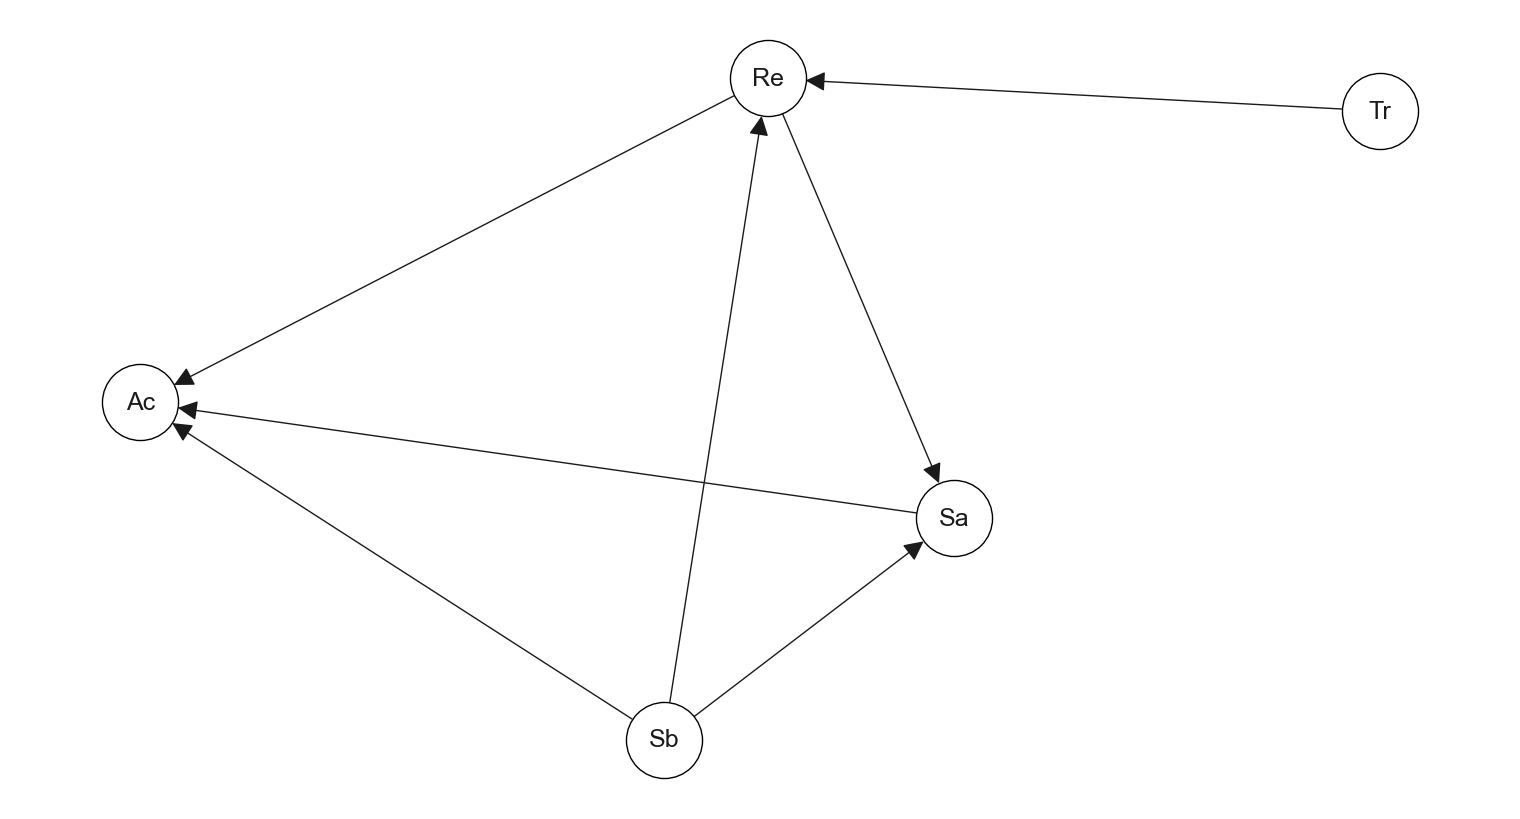

In [31]:
import networkx as nx

G = nx.DiGraph()
G.add_node('Sa')
G.add_node('Sb')
G.add_node('Re')
G.add_node('Ac')
G.add_node('Tr')

G.add_edge('Tr', 'Re')
G.add_edge('Sb', 'Re')
G.add_edge('Sb', 'Sa')
G.add_edge('Re', 'Sa')
G.add_edge('Re', 'Ac')
G.add_edge('Sa', 'Ac')
G.add_edge('Sb', 'Ac')

nx.draw(G, with_labels=True, node_size=3000, node_color='white', edgecolors='black', font_size=18, arrowsize=30)


**3.6** **/Discuss:/** What is the problem of simply comparing the outcomes of papers that had rebuttals with those that did not? Give a concrete example.

In [32]:
print('Papers with low before score accepted:', acl_df[(acl_df.status == 'Accept') & (acl_df.overall_score_before_avg < 2.5)]['status'].count())
print('Total number of papers accepted:', acl_df[(acl_df.status == 'Accept')]['status'].count())

Papers with low before score accepted: 5
Total number of papers accepted: 379


In [33]:
print('Average before score of paper that submitted a rebuttal:', acl_df[(acl_df.had_rebuttal == True)].overall_score_before_avg.mean())
print('Average before score of paper that didn\'t submitted a rebuttal:', acl_df[(acl_df.had_rebuttal == False)].overall_score_before_avg.mean())

Average before score of paper that submitted a rebuttal: 3.347133668903803
Average before score of paper that didn't submitted a rebuttal: 2.528179190751445


The main problem of following such an approach is that the distribution of scores of the two groups (rebuttal or not) may not be the same. Using this method may not actually predict whether submitting a rebuttal has an influence on acceptance, as the score before is a confounder in the problem.

More concretely, papers with very low score have little incentive to write rebuttal, as they have very small chances of getting accepted. This is very evident in the plot in section 1.2, where only 5 papers out of the accepted 379 had a score before lower than 2.5. 

Therefore the analysis may be biased by the fact that the group that submitted the rebuttal generally have a higher score before. It can be seen how the mean score before of papers that submitted a rebuttal is 3.35, way higher than the group who didn't submit a rebuttal (2.53).



# Task 4 (12 pts): Observational study

You decide to use your observational study skills to obtain a concrete answer to the question: do rebuttals increase acceptance?

 **4.1** Perform exact one-to-one matching considering the `score_before_avg` and the `track` variables. Each paper that had a rebuttal ("treatment group") should be matched to a paper that did not have a rebuttal ("control group"). 
- Your matching should be optimal, i.e., the maximum amount of papers possible must be matched. 
- Print the dataframe of papers in the matched sample

In [34]:
acl_df_with_one_hot_std = acl_df_with_one_hot[['overall_score_before_avg', 'had_rebuttal_int', 'track']].copy()

acl_df_with_one_hot_std.reset_index(inplace=True)

treat_list = acl_df_with_one_hot_std[acl_df_with_one_hot_std.had_rebuttal_int == 1].drop(columns=['had_rebuttal_int']).to_numpy().tolist()
contr_list = acl_df_with_one_hot_std[acl_df_with_one_hot_std.had_rebuttal_int == 0].drop(columns=['had_rebuttal_int']).to_numpy().tolist()

In [35]:
ids_list = []
contr_list_noindex = [contr[1:] for contr in contr_list]

for treat in treat_list:
    if treat[1:] in contr_list_noindex:
        index = contr_list_noindex.index(treat[1:])
        ids_list.append(treat[0])
        ids_list.append(contr_list[index][0])
        contr_list_noindex.pop(index)
        contr_list.pop(index)

In [36]:
matched_df = acl_df_with_one_hot.loc[ids_list].copy()

In [37]:
display(matched_df)

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,...,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot,had_rebuttal_int,accepted_int
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,...,0,0,0,0,0,0,0,0,1,0
192,P193,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.500000,2.500000,0.500000,...,0,0,0,0,0,0,0,0,0,0
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,...,0,0,0,0,0,0,0,0,1,0
1432,P1433,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,3.333333,3.333333,0.942809,...,0,0,0,0,0,0,0,0,0,0
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,P1460,Reject,Short,Textual Inference and Other Areas of Semantics,"{'2': {'scores': {'originality': 3, 'soundness...","{'2': {'scores': {'originality': 3, 'soundness...",False,2.000000,2.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
1484,P1485,Reject,Short,Textual Inference and Other Areas of Semantics,"{'1': {'scores': {'originality': 1, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.000000,2.500000,1.000000,...,0,0,0,0,0,1,0,0,1,0
1517,P1518,Reject,Short,Textual Inference and Other Areas of Semantics,"{'2': {'scores': {'originality': 3, 'soundness...","{'2': {'scores': {'originality': 3, 'soundness...",False,2.000000,2.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
1497,P1498,Reject,Short,Generation,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.333333,2.333333,1.247219,...,0,0,0,0,0,0,0,0,1,0


**4.2** So far, we did not consider the `score_before_std` variable. One could argue that the variance in the scores makes a difference. E.g., a paper that received scores 1 and 5, might be very different from a paper with scores 3 and 3. 

Note that you did not match on the `score_before_std` variable. However, it suffices if this variable is "balanced" across treatment and control groups.
 Use the Standardized Mean Difference (SMD) to assess whether that's the case.

- The standardized mean difference for a variable $x$ and two groups $t$ and $c$ is defined as: $\frac{| E[x_t] - E[x_c] |}{\sqrt{Var[x_t] + Var[x_c]}}$

- Note that a Standardized Mean Difference smaller than 0.1 suggests that variables are balanced across treatment and control groups.


In [38]:
matched_treatment_df = matched_df[matched_df['had_rebuttal_int'] == 1]
matched_control_df = matched_df[matched_df['had_rebuttal_int'] == 0]

smd = np.abs(np.mean(matched_treatment_df['overall_score_before_std'])-np.mean(matched_control_df['overall_score_before_std']))/(
    np.sqrt(np.var(matched_treatment_df['overall_score_before_std'])+np.var(matched_control_df['overall_score_before_std'])))

print(f'The Standardized Mean Difference is: {smd:.4f}')

The Standardized Mean Difference is: 0.0453


The variables are balanced across treatment and control groups, as the SMD is smaller than 0.1 for all variables. There is therefore no need to perform matching for this variable.


**4.3** Using the matched sample, estimate the following linear regression: `accepted ~ had_rebuttal_int`.


In [39]:
mod_linear = smf.ols(formula='accepted_int ~ C(had_rebuttal_int)', data=matched_df)
res_linear = mod_linear.fit()
print(res_linear.summary())

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                 6.877e-13
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               1.00
Time:                        14:34:17   Log-Likelihood:                -124.36
No. Observations:                 542   AIC:                             252.7
Df Residuals:                     540   BIC:                             261.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               


**4.4** **/Discuss:/**

i. Considering your results obtained in 4.3, and the causal diagram drawn in Task 3: do rebuttals increase the chance of a paper getting accepted? Why are results different from what you obtained in **Task 1?**

ii. Why is there no need to include other covariates (e.g., score before) in the regression?

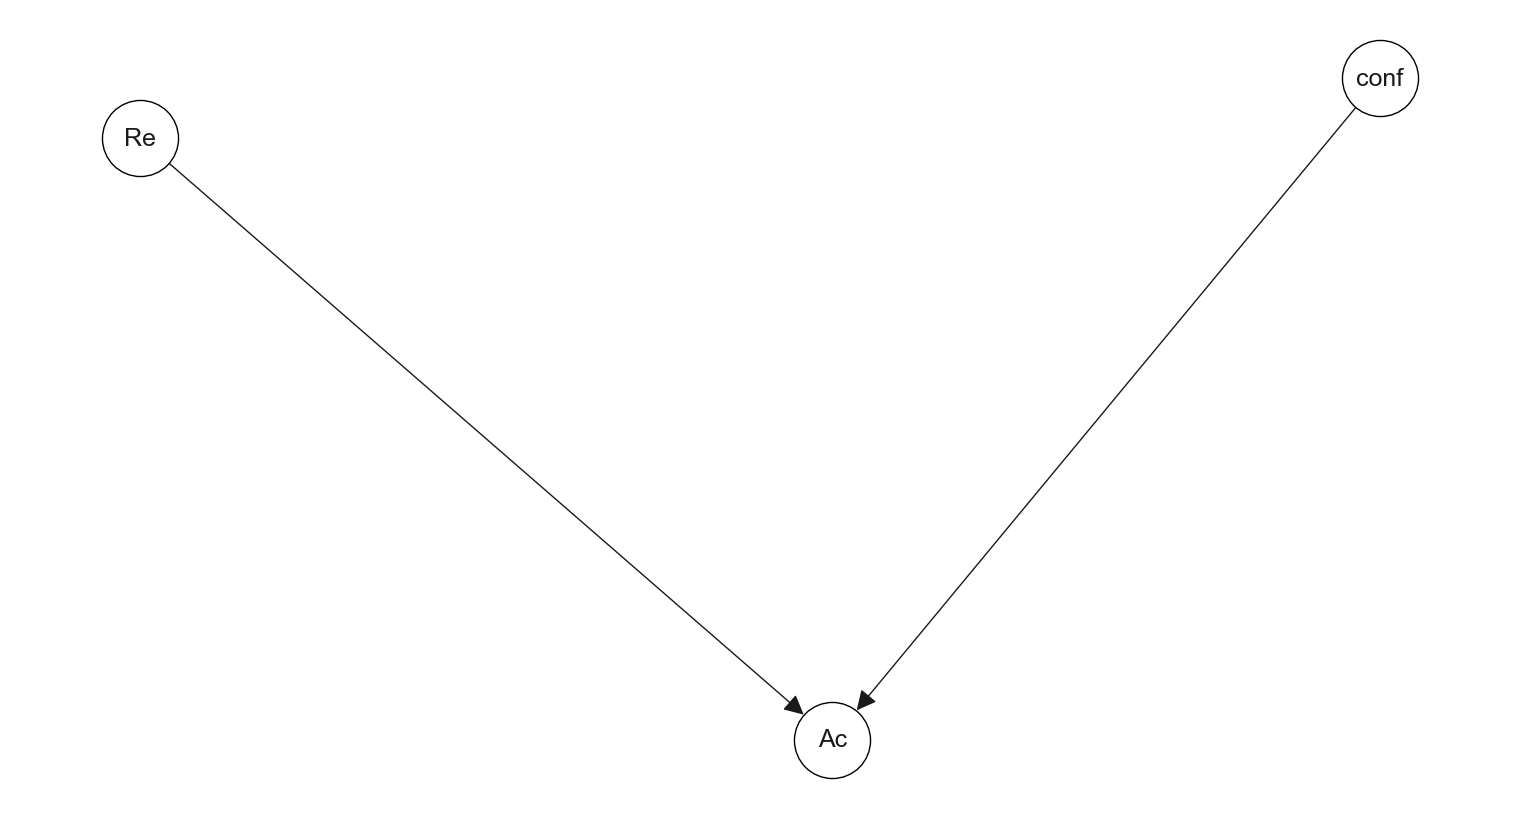

In [40]:
import networkx as nx

G = nx.DiGraph()
G.add_node('conf')
G.add_node('Re')
G.add_node('Ac')

G.add_edge('Re', 'Ac')
G.add_edge('conf', 'Ac')

nx.draw(G, with_labels=True, node_size=3000, node_color='white', edgecolors='black', font_size=18, arrowsize=30)


i. In the new configuration, we control for confounder effect thanks to our matching, thus essentially removing the arrow from confounder - conf - to Re in the causal diagram above for the matched subset of the data. The matching therefore allows us to directly assess whether rebuttals have an impact on acceptance or not, which was not the case in __Task 1__ (confounder effects were not controlled, leaving us to think that rebuttals might have an impact on acceptance). 

Our regression analysis shows that the R² between rebuttals and acceptance is virtually 0 and that the null hypothesis that the coefficient is zero can't be rejected (p-value=1). Rebuttals therefore don't increase the chances of a paper getting accepted.

ii. With exact matching, we obtain similar distributions for the independent variables of both groups. So the relation between the variable we are studying (rebuttal) and the output (acceptance) it is not influenced by other confounder variable (e .g. score before rebuttal). If we add them in the regression the p-value of the coefficient of had_rebuttal will not change.

**4.5** **/Discuss:/** Imagine there is another, unobserved variable "quality" which captures the true quality of the paper. Suppose quality ("Qu") is connected to the DAG you drew in the following ways:
- Qu -> Sa
- Qu -> Sb
- Qu -> Re
- Qu -> Ac
Assume that
- quality can only increase the chances of rebuttals;
- quality and the rebuttal can only increase the chance of a paper being accepted.
Does this uncontrolled confounder threaten the validity of your findings?


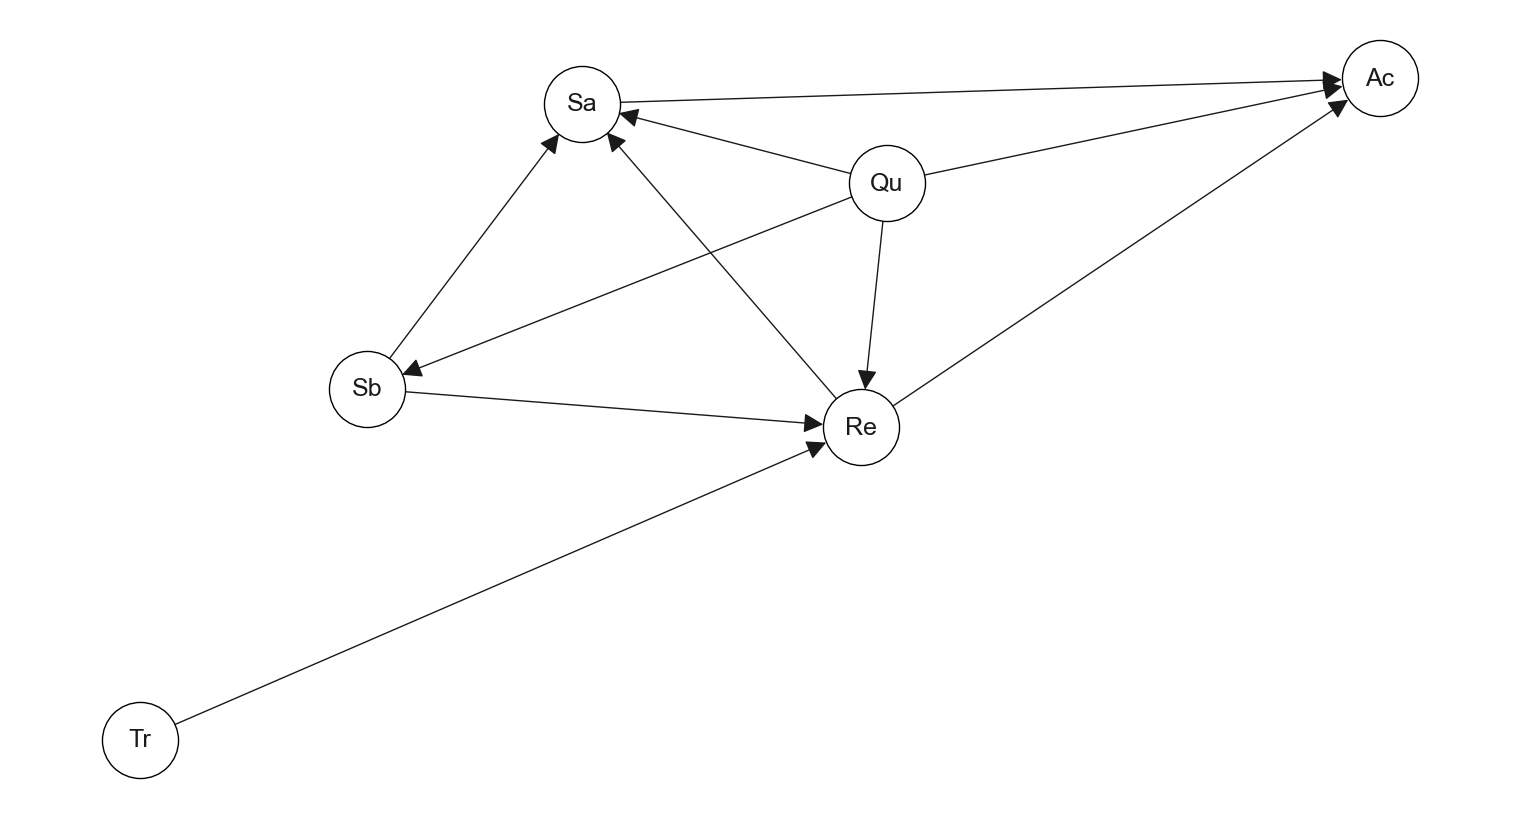

In [41]:
G = nx.DiGraph()
G.add_node('Sa')
G.add_node('Sb')
G.add_node('Re')
G.add_node('Ac')
G.add_node('Tr')
G.add_node('Qu')

G.add_edge('Tr', 'Re')
G.add_edge('Sb', 'Re')
G.add_edge('Sb', 'Sa')
G.add_edge('Re', 'Sa')
G.add_edge('Re', 'Ac')
G.add_edge('Sa', 'Ac')
G.add_edge('Qu', 'Sa')
G.add_edge('Qu', 'Sb')
G.add_edge('Qu', 'Re')
G.add_edge('Qu', 'Ac')

nx.draw(G, with_labels=True, node_size=3000, node_color='white', edgecolors='black', font_size=18, arrowsize=30)


Given the assumptions above, the validity of our findings is not threatened.

The main issue with the introduction of quality is that it is a confounder in the trio quality - rebuttals - acceptance (assumptions 3 and 4 above) that is not matched for. There is a therefore a chance that the conclusion that rebuttals have no impact on acceptance made in the previous point (with other covariates matched for) is actually due to the following: in the matched samples studied above, any impact (whether increase or decrease) on acceptance due to the variable "had_rebuttal" happened to be exactly countered by an inverse impact of the confounder "quality".

There are issues with this hypothesis, though:
- First, it is very unlikely that rebuttals and quality have such precise opposite effects (cancelling each other so perfectly);
- Second, this counter-effect is excluded by the last two hypotheses made above. If quality only increases rebuttals, and both quality and rebuttals only increase acceptance, then the impact of the two variables on acceptance is supposed to be in the same direction (either both cause an increase, or both cause a decrease). This excludes that the two variables had opposite effects that cancelled each other.

# Appendix

### Proof Pearson - squared correlation equality 
Let's prove that the squared Pearson correalation coefficient between the fitted value $\hat{y}$ and $y$ is equal to the R2 score

Consider Pearson's correlation definition:
$$\rho^2 = \left(\frac{\text{Cov}(y, \hat{y})}{\sqrt{\text{Var}(y) \cdot \text{Var}(\hat{y})}}\right)^2
= \frac{\text{Cov}(y, \hat{y}) \cdot \text{Cov}(y, \hat{y})}{\text{Var}(y) \cdot \text{Var}(\hat{y})} $$
Using Covariance properties:
$$= \frac{\text{Cov}(\hat{y} + e, \hat{y}) \cdot \text{Cov}(\hat{y} + e, \hat{y})}{\text{Var}(y) \cdot \text{Var}(\hat{y})}
= \frac{(\text{Cov}(\hat{y}, \hat{y}) + \text{Cov}(\hat{y}, e))(\text{Cov}(\hat{y}, \hat{y}) + \text{Cov}(\hat{y}, e))}{\text{Var}(y) \cdot \text{Var}(\hat{y})}$$
$$=\frac{\text{Cov}(\hat{y}, \hat{y}) \cdot \text{Cov}(\hat{y}, \hat{y})}{\text{Var}(y) \cdot \text{Var}(\hat{y})}= \frac{\text{Var}(\hat{y})}{\text{Var}(y)} = 
\frac{\sum_{i=1}^{n} (\hat{y}_i - \bar{\hat{y}})^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} = R^2
$$


Let's generalize the previous proof for $y$ and $x$. We want to prove that the squared Pearson correalation coefficient between the fitted value $y$ and $x$ is equal to the R2 score

The squared Pearson correlation between y and x is given by:
$$\rho^2 = \left(\frac{\text{Cov}(y, x)}{\sqrt{\text{Var}(y) \cdot \text{Var}(x)}}\right)^2
$$
We also have that the Pearson correlation between $\hat{y}$ and $x$ (in a simple regression with one
explanatory variable where $\hat{y} = ax + b$) is given by:

$$\rho^2 = \left(\frac{\text{Cov}(\hat{y}, x)}{\sqrt{\text{Var}(\hat{y}) \cdot \text{Var}(x)}}\right)^2
= \left(\frac{\text{Cov}(ax + b, x)}{\sqrt{\text{Var}(ax + b) \cdot \text{Var}(x)}}\right)^2 = 1
$$
Therefore, we have that:
$$\rho^2 = \left(\frac{\text{Cov}(y, x)}{\sqrt{\text{Var}(y) \cdot \text{Var}(x)}}\right)^2
= \left(\frac{\text{Cov}(y, \frac{1}{a}(\hat{y} - b))}{\sqrt{\text{Var}(y) \cdot \text{Var}(\frac{1}{a}(\hat{y} - b))}}\right)^2
= \left(\frac{\text{Cov}(y, \hat{y})}{\sqrt{\text{Var}(y) \cdot \text{Var}(\hat{y})}}\right)^2 = R^2
$$